---

In the [last post](https://tmthyjames.github.io/posts/Analyzing-Rap-Lyrics-Using-Word-Vectors/) we analyzed rap lyrics using word vectors. We mostly did some first-pass analysis and very little prediction. In this post, we'll actually focus on predictions and visualizing our results. I'll use Python's machine-learning library, <a href="http://scikit-learn.org/stable/">scikit-learn</a> to build a <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier">naive Bayes</a> to predict a song's genre given its lyrics. To get the data, we'll use [Cypher](https://github.com/tmthyjames/cypher), a new Python package [I recently released](https://tmthyjames.github.io/tools/Cypher/) that retrieves music lyrics. To visualize the results, I'll use [D3](https://d3js.org/) and [D3Plus](https://d3plus.org/), which is a nice wrapper for D3.

## Contents

• [Quick Note on Naive Bayes](#Quick-Note-on-Naive-Bayes)<br/>
• [Getting the Data](#Getting-the-Data)<br/>
• [Loading the Data](#Loading-the-Data)<br/>
• [Splitting the Data](#Splitting-the-Data)<br/>
• [Training the Model](#Training-the-Model)<br/>
• [Top Hip Hop Songs](#Top-Hip-Hop-Songs)<br/>
• [Hip Hop Songs that have Alt Rock and Country Lyrics](#Hip-Hop-Songs-that-have-Alt-Rock-and-Country-Lyrics)<br/>
• [Visualizing Our results](#Visualizing-Our-Results) (With d3.js)<br/>
• [Up Next](#Up-Next)<br/>

## Quick Note on Naive Bayes

The naive Bayes classifier is based on [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) and known for its simplicity, accuracy, and speed, particularly when it comes to text classification, which is what our aim is for this post. In short, as Wikipedia puts it, Bayes' Theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event. For example, if a musical genre is related to lyrics, then, with Bayes' Theorem, we can more accuarately assess the probability that a certain song belongs to a particular genre, compared to the assessment of the probability of a genre made without knowledge of a song's lyrics. For more on Bayes' Theorem, check this [post](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) out. 

## Getting the Data

The data was retrieved with [Cypher](https://github.com/tmthyjames/cypher). The data and code used for this post is available on the Cypher's [GitHub page](https://github.com/tmthyjames/cypher). Since the data takes so long to retrieve (there are over 900 hundred artists), I plan on adding a feature to Cypher that allows the user to load already-retrieved data if it exists, other wise it will retrieve the data like normal. For now, you can just download it from the [GitHub page](https://github.com/tmthyjames/cypher).

I started this post with the intention of trying to classify 11 genres: pop, blues, heavy metal, classic rock, indie folk, RnB, punk rock, screamo, country, and rap.

I ran into a few problems with this as classic rock lyrically was very similar to country; indie folk was also similar to country; punk rock, heavy metal, and screamo were all similar; and RnB and rap were very similar. It's not surprising; as the number of classes grows, it becomes harder to correctly classify. I may write a post on my trouble with this approach if there is interest in it.

Anyways, to get the data, I used [Ranker](https://ranker.com) to get a list of the top artists of each genre. They have a nice API endpoint you can hit to get all the artists so you don't have to web scrape. 

## Loading the Data

To load the data, we'll use [pandas'](https://pandas.pydata.org/) `read_csv` method. We'll also clean up the genres due to the problems mentioned above about lyric similarity. The three genres we'll try to predict are country, rap, and alt rock since those genres are clearly different. For our purposes, we'll classify metal, punk, and screamo as "alt rock". Here's how we do it:

In [38]:
import pandas as pd
import numpy as np

df = pd.read_csv('lyrics.csv')

df['ranker_genre'] = np.where(
    (df['ranker_genre'] == 'screamo')|
    (df['ranker_genre'] == 'punk rock')|
    (df['ranker_genre'] == 'heavy metal'), 
    'alt rock', 
    df['ranker_genre']
)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The data is available as one lyric per row. To train our classifier, we'll need to transform it into one *song* per row. We'll also go ahead and convert the data to lowercase with `.apply(lambda x: x.lower())`. To do that, we do the following:

In [39]:
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']
lyrics_by_song = df.sort_values(group)\
        .groupby(group).lyric\
        .apply(' '.join)\
        .apply(lambda x: x.lower())\
        .reset_index(name='lyric')

lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')

## Splitting the Data

Next we'll split our data into a training set and a testing set using only Country, Alt Rock, and Hip Hop. A quick note: because the lyrics are community-sourced some of the songs have complete or incorrect lyrics. A lot of the songs with less than 400 characters are just strings of nonsense characters. Therefore, I filtered those songs out as they didn't contribute any value or insight to the model.

In [40]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords

genres = [
    'Country', 'alt rock', 'Hip Hop',
]

LYRIC_LEN = 400 # each song has to be > 400 characters
N = 10000 # number of records to pull from each genre
RANDOM_SEED = 200 # random seed to make results repeatable

train_df = pd.DataFrame()
test_df = pd.DataFrame()
for genre in genres:
    subset = lyrics_by_song[
        (lyrics_by_song.ranker_genre==genre) & 
        (lyrics_by_song.lyric.str.len() > LYRIC_LEN)
    ]
    train_set = subset.sample(n=N, random_state=RANDOM_SEED)
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set)
    test_df = test_df.append(test_set)
    
train_df = shuffle(train_df)
test_df = shuffle(test_df)

## Training the Model

Next, we'll train a model using word frequencies and `sklearn`'s `CountVectorizer`. The `CountVectorizer` is a quick and dirty way to train a language model by using simple word counts. Later we'll try a more sophisticated approach with the `TfidfVectorizer`.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# define our model
text_clf = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.87216733086518738

Not a bad first-pass model!

Word frequencies work fine here, but let's see if we can get a better model by using the `TfidfVectorizer`.

`tf-idf` stands for "term frequency-inverse document frequency". `tf` summarizes how often a given word appears within a document, while `idf` scales down words that appear frequently across documents. For example, if we were trying to figure out which rap artists were lyrically similar, the term `police` may not be very helpful as almost every rapper uses this term. But the term `compton` may carry more weight as only a hand full of rappers use it. Thus, although `police` would have a higher `tf` score, `compton` would have a higher `tf-idf` score and would be a more important feature in a language model.

So let's train a model using `tf-idf` scores as features.

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.8641969486169736

Hmmm. Our model seems to have gotten worse. Let's try tuning a few hyperparameters, lemmatizing our data, customizing our tokenizer a bit, and filtering our words with `nltk`'s builtin stopword list.

In [99]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

stop = list(set(stopwords.words('english'))) # stopwords
stop += ['a', 'about', 'above', 'across', 'act', 'afraid', 'again', 'against', 'ago', 'ahead', 'air', 'alive', 'all', 'almost', 'alone', 'always', 'am', 'an', 'and', 'angel', 'angels', 'another', 'answer', 'anymore', 'anything', 'apart', 'are', 'arms', 'around', 'as', 'ask', 'at', 'away', 'baby', 'back', 'bad', 'be', 'beautiful', 'because', 'become', 'bed', 'been', 'before', 'behind', 'believe', 'best', 'better', 'between', 'big', 'black', 'blame', 'blood', 'bones', 'born', 'both', 'break', 'breaking', 'breathe', 'bright', 'bring', 'broken', 'brother', 'built', 'burn', 'burning', 'but', 'buy', 'by', 'call', 'calling', 'came', 'can', 'cannot', 'cant', 'care', 'caught', 'cause', 'chance', 'change', 'children', 'choice', 'city', 'clear', 'closer', 'cold', 'come', 'comes', 'coming', 'control', 'could', 'couldnt', 'cover', 'cross', 'cut', 'damn', 'dance', 'dark', 'darkness', 'day', 'days', 'dead', 'death', 'deep', 'devil', 'did', 'didnt', 'die', 'died', 'different', 'do', 'does', 'doesnt', 'done', 'dont', 'down', 'dream', 'dreams', 'drink', 'earth', 'eat', 'else', 'em', 'empty', 'end', 'ends', 'enough', 'escape', 'even', 'ever', 'every', 'everybody', 'everything', 'evil', 'eye', 'eyes', 'face', 'fade', 'faith', 'fall', 'far', 'fate', 'father', 'fear', 'feel', 'feeling', 'fell', 'fight', 'fighting', 'finally', 'find', 'fire', 'first', 'floor', 'fly', 'for', 'forever', 'forget', 'forgive', 'found', 'free', 'friend', 'friends', 'from', 'front', 'game', 'gave', 'get', 'gets', 'girl', 'give', 'go', 'god', 'goes', 'goin', 'going', 'gold', 'gone', 'gonna', 'good', 'goodbye', 'got', 'grave', 'great', 'ground', 'grow', 'gun', 'had', 'half', 'hand', 'hands', 'happened', 'hard', 'has', 'hate', 'have', 'he', 'head', 'hear', 'heard', 'heart', 'hearts', 'heaven', 'hell', 'help', 'her', 'here', 'hes', 'hey', 'hide', 'high', 'him', 'his', 'home', 'hope', 'hour', 'how', 'i', 'id', 'if', 'ill', 'im', 'in', 'inside', 'instead', 'into', 'is', 'it', 'its', 'ive', 'just', 'keeps', 'kept', 'kill', 'kiss', 'knees', 'know', 'known', 'land', 'last', 'laugh', 'lay', 'learn', 'learned', 'least', 'leave', 'leaving', 'left', 'less', 'let', 'lets', 'lie', 'lies', 'life', 'light', 'lights', 'like', 'line', 'lines', 'little', 'live', 'lived', 'lives', 'living', 'long', 'longer', 'look', 'looking', 'lord', 'lose', 'losing', 'lost', 'lot', 'loud', 'love', 'loves', 'mad', 'made', 'make', 'makes', 'man', 'many', 'matter', 'maybe', 'me', 'meant', 'meet', 'memory', 'men', 'middle', 'million', 'mind', 'mine', 'moment', 'moon', 'more', 'mother', 'much', 'my', 'myself', 'name', 'near', 'neck', 'need', 'never', 'new', 'night', 'nights', 'no', 'none', 'not', 'nothing', 'now', 'of', 'off', 'oh', 'old', 'on', 'once', 'one', 'ones', 'only', 'open', 'or', 'other', 'others', 'our', 'out', 'over', 'own', 'paid', 'pain', 'past', 'pay', 'people', 'perfect', 'pieces', 'place', 'play', 'played', 'pray', 'pretend', 'pretty', 'price', 'pride', 'promise', 'prove', 'put', 'race', 'rain', 'raise', 'ran', 'read', 'real', 'really', 'red', 'remember', 'rest', 'ride', 'right', 'rise', 'run', 'running', 'safe', 'said', 'same', 'save', 'saw', 'say', 'saying', 'scared', 'scream', 'second', 'see', 'seem', 'seems', 'seen', 'send', 'set', 'she', 'shell', 'short', 'should', 'show', 'sick', 'side', 'sight', 'sign', 'silence', 'simple', 'sin', 'sing', 'singing', 'single', 'six', 'sky', 'sleeping', 'slow', 'smell', 'so', 'some', 'someone', 'something', 'song', 'sorry', 'soul', 'sound', 'space', 'speak', 'stand', 'start', 'started', 'steal', 'still', 'stop', 'story', 'straight', 'streets', 'stuck', 'such', 'sun', 'sure', 'swear', 'sweet', 'take', 'taken', 'taking', 'taste', 'tear', 'tell', 'than', 'that', 'thats', 'the', 'them', 'then', 'there', 'theres', 'these', 'they', 'theyre', 'thing', 'things', 'think', 'thinking', 'this', 'thought', 'thousand', 'three', 'through', 'tight', 'time', 'times', 'tired', 'to', 'today', 'told', 'tomorrow', 'tongue', 'tonight', 'too', 'took', 'touch', 'tried', 'truth', 'try', 'turning', 'two', 'under', 'until', 'up', 'upon', 'us', 'used', 'wait', 'waiting', 'walk', 'wall', 'walls', 'wanna', 'want', 'wanted', 'war', 'was', 'watch', 'watching', 'way', 'we', 'weak', 'welcome', 'well', 'were', 'weve', 'what', 'whatever', 'whats', 'when', 'where', 'white', 'who', 'whos', 'why', 'wide', 'wild', 'will', 'with', 'within', 'without', 'wont', 'words', 'world', 'worlds', 'would', 'wouldnt', 'write', 'wrong', 'ya', 'yeah', 'year', 'yet', 'you', 'youd', 'young', 'your', 'youre', 'yourself', 'youve', 'after', 'aint', 'along', 'any', 'anyone', 'anyway', 'asked', 'beat', 'begin', 'being', 'belong', 'bet', 'bit', 'blind', 'blow', 'blue', 'body', 'book', 'bound', 'boys', 'breath', 'broke', 'brought', 'catch', 'changed', 'choose', 'close', 'clouds', 'cool', 'corner', 'count', 'crazy', 'crime', 'cry', 'crying', 'dear', 'dog', 'doing', 'door', 'doors', 'doubt', 'drive', 'dust', 'dying', 'each', 'easy', 'everyone', 'everywhere', 'faces', 'falling', 'family', 'fast', 'feelings', 'feels', 'felt', 'few', 'filled', 'fine', 'fingers', 'fit', 'flame', 'follow', 'fool', 'four', 'full', 'fun', 'future', 'getting', 'girls', 'given', 'giving', 'gotta', 'green', 'guess', 'hair', 'hanging', 'happy', 'heads', 'heavy', 'held', 'heres', 'hit', 'hold', 'hole', 'hot', 'house', 'hundred', 'hurt', 'isnt', 'keep', 'key', 'kids', 'kind', 'king', 'knew', 'knowing', 'knows', 'late', 'lead', 'lifes', 'listen', 'looked', 'looks', 'may', 'mean', 'means', 'mess', 'might', 'minds', 'mirror', 'money', 'most', 'move', 'moving', 'music', 'must', 'news', 'next', 'nice', 'nobody', 'nowhere', 'part', 'pass', 'path', 'peace', 'pick', 'picture', 'piece', 'plan', 'playing', 'please', 'point', 'power', 'pull', 'push', 'rather', 'reach', 'ready', 'realize', 'reason', 'road', 'rock', 'room', 'sad', 'says', 'scene', 'school', 'sense', 'shame', 'share', 'shed', 'shes', 'shine', 'shut', 'since', 'sit', 'skin', 'sleep', 'small', 'smile', 'somebody', 'sometimes', 'somewhere', 'son', 'songs', 'soon', 'sounds', 'spent', 'standing', 'stare', 'stars', 'starts', 'state', 'stay', 'step', 'street', 'strong', 'takes', 'talk', 'talking', 'ten', 'their', 'theyll', 'those', 'though', 'thoughts', 'till', 'together', 'town', 'trouble', 'true', 'trust', 'trying', 'turn', 'turned', 'understand', 'use', 'very', 'voice', 'walked', 'walking', 'waste', 'water', 'ways', 'wear', 'went', 'which', 'while', 'whole', 'win', 'wind', 'wish', 'wonder', 'word', 'work', 'worth', 'years', 'yes', 'youll', 'already', 'drop', 'everyday', 'feet', 'five', 'glass', 'holding', 'killing', 'lips', 'locked', 'lonely', 'loved', 'low', 'met', 'mouth', 'needs', 'party', 'ring', 'sea', 'sent', 'spend', 'star', 'stone', 'storm', 'throw', 'top', 'twice', 'wings', 'yours', 'ah', 'boy', 'brain', 'called', 'car', 'carry', 'child', 'clean', 'crowd', 'dirty', 'dry', 'hours', 'ice', 'leaves', 'lying', 'making', 'miles', 'morning', 'number', 'passed', 'poor', 'roll', 'round', 'screaming', 'shake', 'shot', 'slowly', 'smoke', 'survive', 'tears', 'telling', 'turns', 'wake', 'wants', 'warm', 'wasnt', 'window', 'woman', 'clothes', 'fill', 'hang', 'miss', 'outside', 'slip', 'memories', 'sand']
wnl = WordNetLemmatizer() # lemmatizer

def tokenizer(x): # custom tokenizer
    return (
        wnl.lemmatize(w) 
        for w in word_tokenize(x) 
        if len(w) > 2 and w.isalnum() # only words that are > 2 characters
    )                                 # and is alpha-numeric

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer(
        ngram_range=(1, 2), # include bigrams
        tokenizer=tokenizer,
        stop_words=stop,
        max_df=0.4, # ignore terms that appear in more than 40% of documents
        min_df=4)), # ignore terms that appear in less than 4 documents
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.85033131322658995

Hey! 1% better. I'll take it. We could keep tuning these hyperparameters to squeeze out more accuracy, but we'll save that for another day. 

Now let's go beyond raw accuracy and see how it performs by looking at our confusion matrix for this model. 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


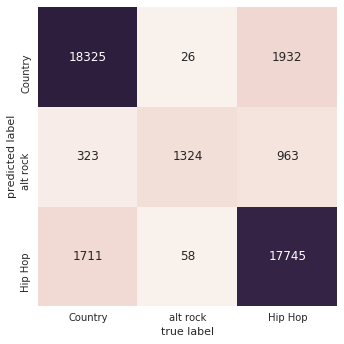

In [36]:
mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

Given this confusion matrix, we can calculate precision, recall, and f-score, which can be better metrics for evaluating a classifier than raw accuracy.

<b>Recall</b> is the ability of the classifier to find all the positive results. That is, to clasify a rap song *as* a rap song. 

<b>Precision</b> is the ability of the classifier to not label a negative result as a positive one. That is, to not classify a rap song as a country song.

<b>F-score</b> is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of precision and recall.

To compute recall, precision, and f-score, we'll use `precision_recall_fscore_support` from `sklearn.metrics`.

In [35]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(test_df.ranker_genre, predicted)

for n,genre in enumerate(genres):
    genre = genre.upper()
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

COUNTRY_precision: 0.9034659567125178
COUNTRY_recall: 0.9000933248194901
COUNTRY_fscore: 0.9017764873775898
COUNTRY_support: 20359

ALT ROCK_precision: 0.5072796934865901
ALT ROCK_recall: 0.9403409090909091
ALT ROCK_fscore: 0.6590343454454953
ALT ROCK_support: 1408

HIP HOP_precision: 0.9093471353899765
HIP HOP_recall: 0.8597383720930233
HIP HOP_fscore: 0.883847188324949
HIP HOP_support: 20640



<b>Support</b> is the number of each class in the actual true set. And the first thing I notice is that there aren't many alt rock songs being scored. Adding more alt rock songs could possibly improve our model. 

We do a good job all around on classifying hip hop and country songs. For alt rock songs, the recall score is great; that is, when it's actually an alt rock song, the model classifies it as an alt rock song 94% of the time. But, as we can see from our alt rock precision score and confusion matrix, the model classifies many hip hop songs as alt rock (963, to be exact), which is the main reason this score is so low.

Let's throw some new data at our model and see how well it does predicting what genre these lyrics belong to. 

In [13]:
text_clf.predict(
    [
        "i stand for the red white and blue",
        "flow so smooth they say i rap in cursive", #bars *insert fire emoji*
        "take my heart and carve it out",
        "there is no end to the madness",
        "sitting on my front porch drinking sweet tea",
        "sitting on my front porch sippin on cognac",
        "dog died and my pick up truck wont start",
        "im invisible and the drugs wont help",
        "i hope you choke in your sleep thinking of me",
        "i wonder what genre a song about data science and naive bayes and hyper parameters and maybe a little scatter plots would be"
    ]
)

array(['Country', 'Hip Hop', 'alt rock', 'alt rock', 'Country', 'Hip Hop',
       'Country', 'alt rock', 'alt rock', 'Hip Hop'], 
      dtype='<U8')

This seems to classify lyrics pretty well. Not sure about that last lyric though. But, then again, maybe the classifier does as good a job as any human would do classifying those cool data science lyrics?

## Top Hip Hop Songs

Let's retrieve the songs with the highest probability of being hip hop. I'm guessing this will be a prolific artist who's language influences the entire genre. First, though, we need to score each song then merge it in to our dataset.

In [100]:
data = train_df.append(test_df) # entire dataset
predicts = text_clf.predict_proba(data.lyric) # score each song

data['Country'], data['Hip_Hop'], data['Alt_Rock'] = ['','',''] # create empty columns
for n,row in enumerate(data.itertuples()): # merge scored data into our dataset
    data.loc[row.Index, 'Country'] = predicts[n][0]
    data.loc[row.Index, 'Hip_Hop'] = predicts[n][1]
    data.loc[row.Index, 'Alt_Rock'] = predicts[n][2]

The top 20 most-hip hop songs are:

In [48]:
columns_of_interest = [
    'artist', 'song', 'album', 
    'ranker_genre', 'Hip_Hop', 
    'Alt_Rock', 'Country'
]

data[columns_of_interest]\
    .sort_values(['Hip_Hop', 'Alt_Rock', 'Country'], ascending=[0, 1, 1])\
    .head(20)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country
89883,Snoop_Dogg,Set It Off,Tha Last Meal (2000),Hip Hop,1,1.02507e-12,2.59403e-13
42315,2Pac,Hit 'Em Up,Live (2004),Hip Hop,1,3.22494e-12,7.39967e-15
42316,2Pac,Hit 'em Up,Greatest Hits (1998),Hip Hop,1,3.25809e-12,8.41491e-15
34832,Too_$hort,Get In Where You Fit In,Get In Where You Fit In (1993),Hip Hop,1,3.50784e-12,2.47664e-15
33580,Snoop_Dogg,Freestyle Conversation,Tha Doggfather (1996),Hip Hop,1,3.01647e-12,9.0946e-13
25109,Snoop_Dogg,Doggy Dogg World,Doggystyle (1993),Hip Hop,1,1.38902e-11,8.70554e-13
25110,Snoop_Dogg,Doggy Dogg World,Death Row's Snoop Doggy Dogg At His Best (2001),Hip Hop,1,1.53723e-11,8.72738e-13
79165,Twista,Overdose,Adrenaline Rush (1997),Hip Hop,1,1.76744e-11,2.68287e-14
25253,Snoop_Dogg,Don Doggy,Paid Tha Cost To Be Da Bo$$ (2002),Hip Hop,1,1.8457e-11,1.12283e-12
91632,MC_Ren,Shot Caller,Ruthless for Life (1998),Hip Hop,1,2.29e-11,6.95705e-13


And the most hip hop song is Set it Off by Snoop Dogg, who also seems to be the most hip hop rapper, as he has 6 of the top 20 most hip hop songs. Also, it shouldn't be surprising that a lot of these songs are pre-2000, which is the age that hip hop really began to take shape. From this analysis, it seems a lot of the language of hip hop was being defined during those years.

Because the lyrics are community-sourced, there are some duplicate songs. In the real world, we'd want to get rid of these duplicate rows.

## Hip Hop Songs that have Alt Rock and Country Lyrics

Next, let's see which hip hop songs have the most alt rock lyrics. To do this, we'll query our data for only hip hop songs and then sort by the `Alt_Rock` column. I don't have any guesses as to which songs this will be. Maybe Childish Gambino? Or Tech N9ne? Let's see.

In [116]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest]\
    .sort_values(['Alt_Rock', 'Hip_Hop'], ascending=[0, 1])\
    .head(20) # Top 20

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country
109588,Busta_Rhymes,There's Only One Year Left!!! (Intro),E.L.E. (Extinction Level Event): The Final World Front (1998),Hip Hop,0.000587058,0.999413,7.39381e-08
3277,Lauryn_Hill,Adam Lives In Theory,MTV Unplugged (2002),Hip Hop,0.00145159,0.998285,0.000263027
114762,Immortal_Technique,Ultimas Palabras,The Martyr (2011),Hip Hop,0.00282868,0.997171,4.61514e-07
46223,Lauryn_Hill,I Get Out,MTV Unplugged (2002),Hip Hop,0.00272789,0.996981,0.000291271
33562,Lauryn_Hill,Freedom Time,MTV Unplugged (2002),Hip Hop,0.00346428,0.996294,0.000241836
61391,Lupe_Fiasco,Letting Go,Lasers (2011),Hip Hop,0.00417445,0.994444,0.00138115
30230,Kid_Cudi,Fade 2 Red,Speedin' Bullet 2 Heaven (2015),Hip Hop,0.00555762,0.993203,0.00123917
115250,Lupe_Fiasco,Unforgivable Youth,Food & Liquor II: The Great American Rap Album Pt. 1 (2012),Hip Hop,0.00624787,0.993113,0.000638979
20096,Kid_Cudi,Copernicus Landing,Satellite Flight: The Journey to Mother Moon (2014),Hip Hop,0.00505283,0.993016,0.00193124
19897,Kid_Cudi,Confused!,Speedin' Bullet 2 Heaven (2015),Hip Hop,0.00505283,0.993016,0.00193124


Wow. Didn't expect some of these results. Lauryn Hill seems to be the alt rock hip hop queen. Although Busta Rhymes has the most alt rock song, Lauryn Hill has 5 of the top 20 and, as we'll see from our visualization below, 12 of the top 100 most alt rock hip hop songs.

Now, let's see which hip hop songs have the most country lyrics. Again, no guesses. Maybe a southern rapper, like Ludacris or Yelawolf?

In [117]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest]\
    .sort_values(['Country'], ascending=[0])\
    .head(20)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country
35371,Ghostface_Killah,Ghostface X-Mas,GhostDeini The Great (2008),Hip Hop,0.0104447,0.00121425,0.988341
51878,Queen_Latifah,If I Had You,The Dana Owens Album (2004),Hip Hop,0.0099924,0.0174937,0.972514
25455,Queen_Latifah,Don't Cry Baby,Trav'lin' Light (2007),Hip Hop,0.0229387,0.0271649,0.949896
107717,Queen_Latifah,The Same Love That Made Me Laugh,The Dana Owens Album (2004),Hip Hop,0.0181416,0.0324947,0.949364
8226,Childish_Gambino,Baby Boy,"""Awaken, My Love!"" (2016)",Hip Hop,0.0130007,0.0379516,0.949048
101930,Yelawolf,Tennessee Love,Trunk Muzik Returns (2013),Hip Hop,0.0537624,0.000793593,0.945444
101931,Yelawolf,Tennessee Love,Love Story (2015),Hip Hop,0.0537624,0.000793593,0.945444
56413,Bizzy_Bone,Jesus,The Gift (2001),Hip Hop,0.0556137,0.0303563,0.91403
31606,Drake,Find Your Love,Thank Me Later (2010),Hip Hop,0.0194045,0.0760984,0.904497
94728,Scarface,Someday,The Fix (2002),Hip Hop,0.0289326,0.0727989,0.898269


Well damn. If Lauryn Hill is the alt rock hip hop queen, then Queen Latifah is the country hip hop queen, at least lyrically.

## Visualizing Our Results

I've also created a dashboard that you can play around with. It visualizes what we just did with our dataframes. Namely, you can look up which songs are most likely to belong to a different genre. In the upper left quadrant, you have the top 1,000 hip hop songs that have alt rock lyrics; you can also choose which genre you'd like to analyze with the drop down options. In the upper right quandrant, there's a table of the top 100 songs based on the filter of the upper left quadrant. In the lower left quadrant, you can see the lyrics weighted by tf-idf scores to allow you to visualize which words are hip hop, alt rock, and country. Lastly, in the lower right quadrant, you have a scatter plot with the tf-idf scores for each word for each genre. This graph is another way of visualizing the lower left quadrant. 

With these graphs, you'll get more insight into why exactly the model classified a song a certain way.

<b>To get started, first select a song from the upper left scatter plot.</b>

---

These results look pretty good, even the alt rock songs. If you choose "Alt_Rock songs that have Hip_Hop lyrics", the top song is Rage Against The Machine's "F\*ck Tha Police" which has obvious hip hop overtones. Some may even say it *is* a hip hop song. Also, among the top of that list are the songs birthed from the Jay-Z-Linkin Park collaboration. 

Also, if you choose "Country songs that have Hip_Hop lyrics" you'll notice that the top song is Taylor Swift's Thug Story featuring T-Pain. The lyrics in the lower left box and the lower right tf-idf scatter plot will show that this song is lyrically hip hop even if musically it couldn't be further from it. 

## Up Next

Next, I'd like to perform some topic modeling on musical lyrics. But I may be putting most of my effort into [Achoo](https://tmthyjames.github.io/tools/prediction/Achoo-beta-0.1/) for the foreseeable future. Either way, I'll be reporting back soon.